In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM
from neuralforecast.losses.pytorch import *
from neuralforecast.utils import PredictionIntervals

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\envs\book-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-02 10:04:04,348	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-02 10:04:05,182	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
data = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


## Forecasting

In [4]:
prompt_prefix = """
    The dataset contains information on weekly sales in four different stores.
    Sales tend to increase in towards the end of the year.
"""

In [5]:
timellm = TimeLLM(
    h=8,
    input_size=16,
    d_llm=768,
    prompt_prefix=prompt_prefix,
    batch_size=16,
    windows_batch_size=16,
    max_steps=150
)

Seed set to 1


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


In [6]:
nf = NeuralForecast(
    models=[timellm],
    freq='W'
)

In [7]:
df = data.drop(['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1)
df.head()

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


In [8]:
nf.fit(
    df=df,
    time_col='Date', 
    target_col='Weekly_Sales',
    id_col='Store'
)
preds = nf.predict()
preds.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 2.1 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.214   Total estimated model params size (MB)


Epoch 99: 100%|██████████████| 1/1 [00:04<00:00,  0.22it/s, v_num=2, train_loss_step=9.74e+4, train_loss_epoch=9.88e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|█████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=2, train_loss_step=1.18e+5, train_loss_epoch=1.18e+5]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|█████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=2, train_loss_step=1.18e+5, train_loss_epoch=1.18e+5]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


,Date,TimeLLM
Store,,
1,2012-10-28,1531876.625
1,2012-11-04,1541158.875
1,2012-11-11,1531402.625
1,2012-11-18,1537673.500
1,2012-11-25,1524842.875


In [10]:
preds = preds.reset_index()
preds.head()

,Store,Date,TimeLLM
0,1,2012-10-28,1531876.625
1,1,2012-11-04,1541158.875
2,1,2012-11-11,1531402.625
3,1,2012-11-18,1537673.500
4,1,2012-11-25,1524842.875


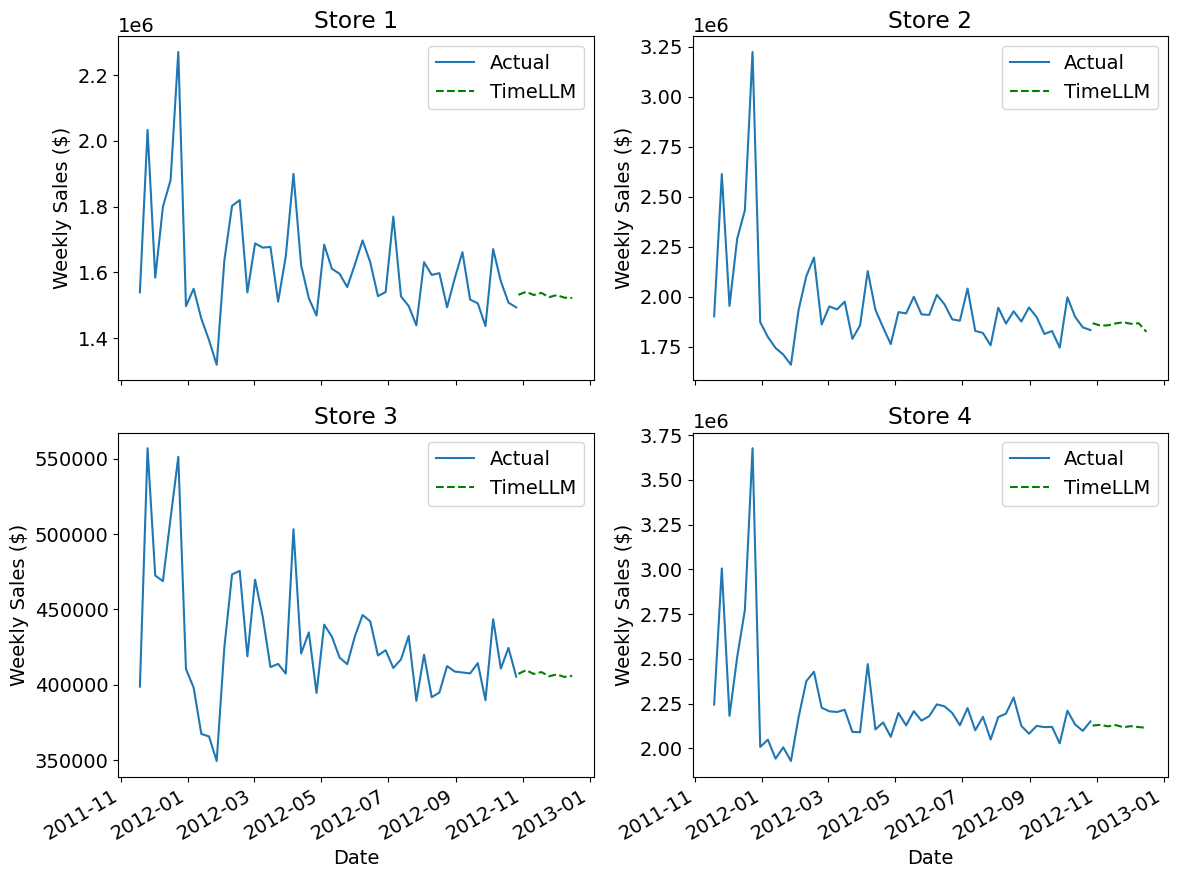

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1][-50:]
    preds_df = preds[preds['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'], label='Actual')
    ax.plot(preds_df['Date'], preds_df['TimeLLM'], 'g--', label='TimeLLM')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH09_codefig1_peixeiro2.png", dpi=300)

## Cross-validation

In [15]:
store1_df = df.query("Store == 1")

In [16]:
cv_df = nf.cross_validation(
    df=store1_df,
    n_windows=4,
    step_size=8,
    refit=False,
    id_col='Store',
    target_col='Weekly_Sales',
    time_col='Date'
)
cv_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 2.1 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.214   Total estimated model params size (MB)


Epoch 99: 100%|██████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=4, train_loss_step=1.05e+5, train_loss_epoch=1.18e+5]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|█████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=4, train_loss_step=9.79e+4, train_loss_epoch=9.79e+4]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|█████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=4, train_loss_step=9.79e+4, train_loss_epoch=9.79e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


,Date,cutoff,TimeLLM,Weekly_Sales
Store,,,,
1,2012-03-23,2012-03-16,1617683.125,1511068.07
1,2012-03-30,2012-03-16,1588611.000,1649604.63
1,2012-04-06,2012-03-16,1589780.250,1899676.88
1,2012-04-13,2012-03-16,1627603.875,1621031.70
1,2012-04-20,2012-03-16,1659881.125,1521577.87


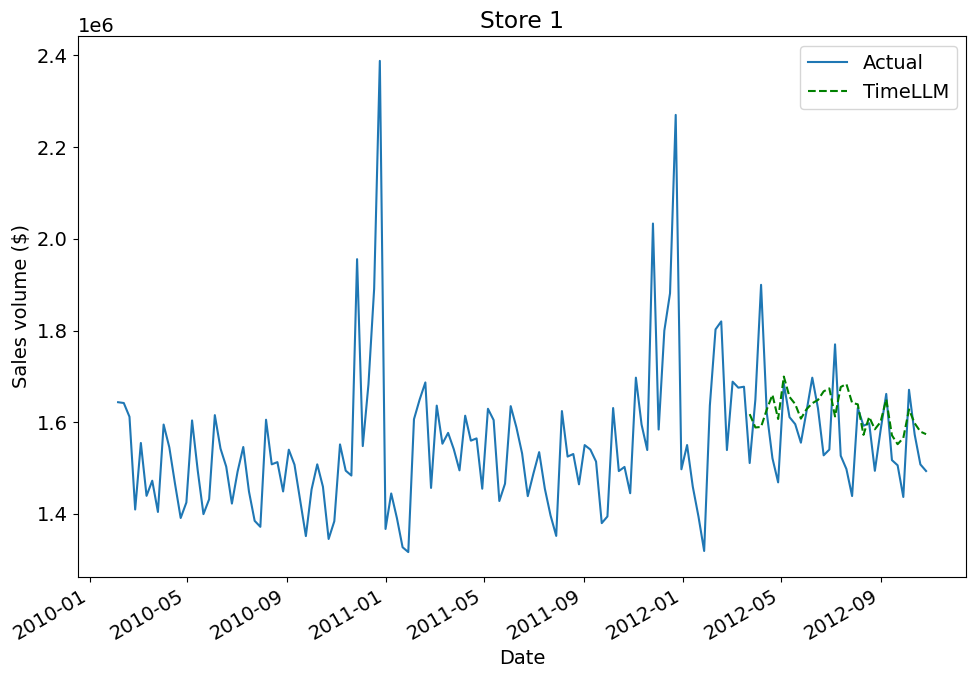

In [19]:
cv_df = cv_df.reset_index()

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'], label='Actual')
ax.plot(cv_df['Date'], cv_df['TimeLLM'], ls='--', color='green', label='TimeLLM')

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig("figures/CH09_codefig2_peixeiro2.png", dpi=300)

In [21]:
test_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=['TimeLLM'],
    target_col='Weekly_Sales',
    id_col='Store'
)
evaluation

,Store,metric,TimeLLM
0,1,mae,80417.364375
1,1,smape,0.025116


## Anomaly detection

In [3]:
df_anomaly = pd.read_csv('../data/nyc_taxi_anomaly_daily.csv', parse_dates=['timestamp'])
df_anomaly['unique_id'] = 1
df_anomaly.head()

,timestamp,value,is_anomaly,unique_id
0,2014-07-01,745967,0,1
1,2014-07-02,733640,0,1
2,2014-07-03,710142,0,1
3,2014-07-04,552565,0,1
4,2014-07-05,555470,0,1


In [5]:
len(df_anomaly)

215

In [5]:
horizon = 20
input_size = 30

prediction_intervals = PredictionIntervals()

prompt_prefix = """
    The dataset contains information on daily taxi rides in New York City.
    There is a weekly seasonality.
"""

timellm = TimeLLM(
    h=horizon,
    input_size=input_size,
    d_llm=768,
    prompt_prefix=prompt_prefix,
    batch_size=16,
    windows_batch_size=16,
    max_steps=10
)

nf = NeuralForecast(models=[timellm], freq='D')

anomaly_cv_df = nf.cross_validation(
    df=df_anomaly,
    n_windows=8,
    step_size=horizon,
    refit=True,
    prediction_intervals=prediction_intervals,
    level=[99],
    target_col='value',
    time_col='timestamp'
)

Seed set to 1


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=34, train_loss_step=6.33e+4, train_loss_epoch=6.53e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=34, train_loss_step=6.33e+4, train_loss_epoch=6.33e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=34, train_loss_step=6.33e+4, train_loss_epoch=6.33e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.22it/s, v_num=36, train_loss_step=4.35e+4, train_loss_epoch=4.44e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=36, train_loss_step=4.35e+4, train_loss_epoch=4.35e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=36, train_loss_step=4.35e+4, train_loss_epoch=4.35e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=38, train_loss_step=4.38e+4, train_loss_epoch=4.24e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=38, train_loss_step=4.38e+4, train_loss_epoch=4.38e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=38, train_loss_step=4.38e+4, train_loss_epoch=4.38e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=40, train_loss_step=6.56e+4, train_loss_epoch=6.36e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=40, train_loss_step=6.56e+4, train_loss_epoch=6.56e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=40, train_loss_step=6.56e+4, train_loss_epoch=6.56e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=42, train_loss_step=6.17e+4, train_loss_epoch=5.87e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=42, train_loss_step=6.17e+4, train_loss_epoch=6.17e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=42, train_loss_step=6.17e+4, train_loss_epoch=6.17e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=44, train_loss_step=5.19e+4, train_loss_epoch=5.37e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=44, train_loss_step=5.19e+4, train_loss_epoch=5.19e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=44, train_loss_step=5.19e+4, train_loss_epoch=5.19e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=46, train_loss_step=5.16e+4, train_loss_epoch=5.29e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=46, train_loss_step=5.16e+4, train_loss_epoch=5.16e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=46, train_loss_step=5.16e+4, train_loss_epoch=5.16e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=48, train_loss_step=4.93e+4, train_loss_epoch=5.59e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=48, train_loss_step=4.93e+4, train_loss_epoch=4.93e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=48, train_loss_step=4.93e+4, train_loss_epoch=4.93e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|███████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=50, train_loss_step=5.7e+4, train_loss_epoch=5.62e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|████████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=50, train_loss_step=5.7e+4, train_loss_epoch=5.7e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|████████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=50, train_loss_step=5.7e+4, train_loss_epoch=5.7e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|███████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=52, train_loss_step=5.1e+4, train_loss_epoch=5.68e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|████████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=52, train_loss_step=5.1e+4, train_loss_epoch=5.1e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|████████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=52, train_loss_step=5.1e+4, train_loss_epoch=5.1e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=54, train_loss_step=5.42e+4, train_loss_epoch=5.85e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=54, train_loss_step=5.42e+4, train_loss_epoch=5.42e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=54, train_loss_step=5.42e+4, train_loss_epoch=5.42e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=56, train_loss_step=5.06e+4, train_loss_epoch=5.29e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=56, train_loss_step=5.06e+4, train_loss_epoch=5.06e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=56, train_loss_step=5.06e+4, train_loss_epoch=5.06e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|███████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=58, train_loss_step=4.9e+4, train_loss_epoch=5.55e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|████████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=58, train_loss_step=4.9e+4, train_loss_epoch=4.9e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|████████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=58, train_loss_step=4.9e+4, train_loss_epoch=4.9e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=60, train_loss_step=5.28e+4, train_loss_epoch=4.72e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=60, train_loss_step=5.28e+4, train_loss_epoch=5.28e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.20it/s, v_num=60, train_loss_step=5.28e+4, train_loss_epoch=5.28e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=62, train_loss_step=4.51e+4, train_loss_epoch=4.42e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=62, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=62, train_loss_step=4.51e+4, train_loss_epoch=4.51e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 7.7 K 
8 | normalize_layers    | RevIN              | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.237   Total estimated model params size (MB)



Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=64, train_loss_step=6.21e+4, train_loss_epoch=5.48e+4]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=64, train_loss_step=6.21e+4, train_loss_epoch=6.21e+4]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 9: 100%|██████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=64, train_loss_step=6.21e+4, train_loss_epoch=6.21e+4]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


In [6]:
anomaly_cv_df = anomaly_cv_df.reset_index()
anomaly_cv_df.head()

,unique_id,timestamp,cutoff,TimeLLM,TimeLLM-lo-99,TimeLLM-hi-99,value
0,1,2014-08-25,2014-08-24,707983.9375,680485.982187,735481.892813,601875
1,1,2014-08-26,2014-08-24,694835.8125,648512.916562,741158.708437,652836
2,1,2014-08-27,2014-08-24,747148.6875,637970.077187,856327.297813,697228
3,1,2014-08-28,2014-08-24,711901.0625,691834.250000,731967.875000,695717
4,1,2014-08-29,2014-08-24,681568.7500,466689.070000,896448.430000,699744


In [7]:
anomaly_cv_df['anomaly'] = (
    (anomaly_cv_df['value'] < anomaly_cv_df['TimeLLM-lo-99']) | \
    (anomaly_cv_df['value'] > anomaly_cv_df['TimeLLM-hi-99'])
).astype(int)

anomaly_cv_df.head()

,unique_id,timestamp,cutoff,TimeLLM,TimeLLM-lo-99,TimeLLM-hi-99,value,anomaly
0,1,2014-08-25,2014-08-24,707983.9375,680485.982187,735481.892813,601875,1
1,1,2014-08-26,2014-08-24,694835.8125,648512.916562,741158.708437,652836,0
2,1,2014-08-27,2014-08-24,747148.6875,637970.077187,856327.297813,697228,0
3,1,2014-08-28,2014-08-24,711901.0625,691834.250000,731967.875000,695717,0
4,1,2014-08-29,2014-08-24,681568.7500,466689.070000,896448.430000,699744,0


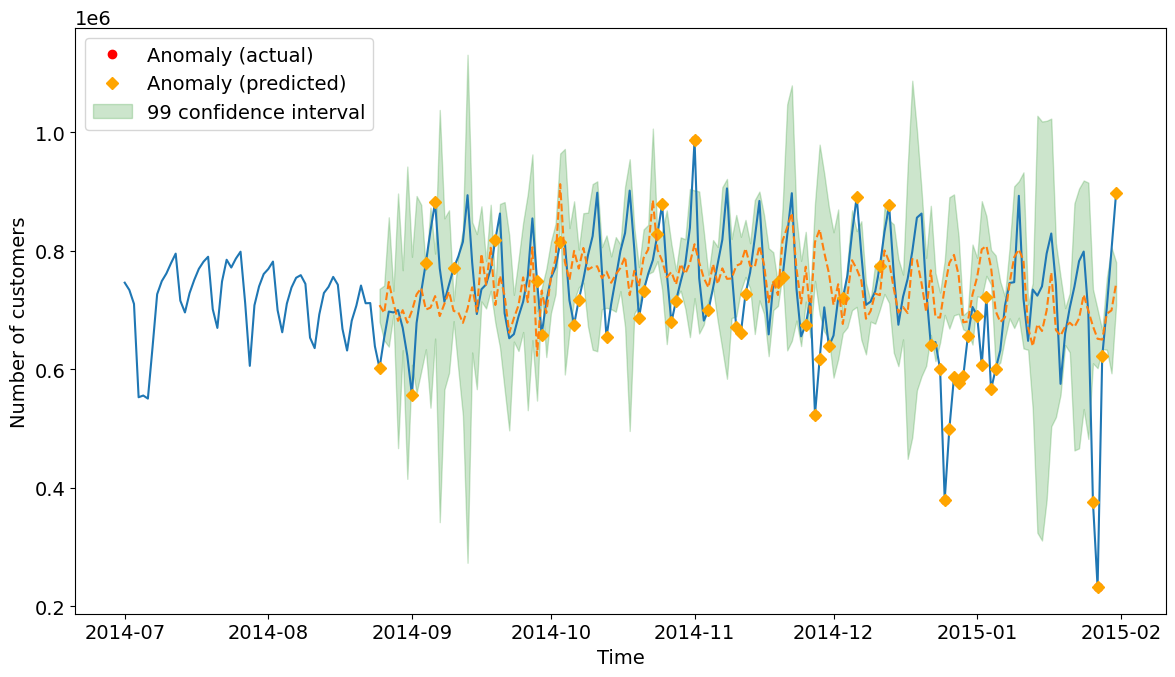

In [8]:
actual_anomaly_df = df_anomaly.loc[df_anomaly['is_anomaly'] == 1]
pred_anomaly_df = anomaly_cv_df.loc[anomaly_cv_df['anomaly'] == 1] 

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df_anomaly['timestamp'], df_anomaly['value'])
ax.plot(actual_anomaly_df['timestamp'], actual_anomaly_df['value'], 'o', color='red', label='Anomaly (actual)')
ax.plot(pred_anomaly_df['timestamp'], pred_anomaly_df['value'], 'D', color='orange', label='Anomaly (predicted)')
ax.plot(anomaly_cv_df['timestamp'], anomaly_cv_df['TimeLLM'], ls='--')
ax.fill_between(anomaly_cv_df['timestamp'], anomaly_cv_df['TimeLLM-lo-99'], anomaly_cv_df['TimeLLM-hi-99'], color='green', alpha=0.2, label='99 confidence interval')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc=2)

plt.tight_layout()
plt.savefig("figures/CH09_codefig3_peixeiro2.png", dpi=300)

In [9]:
def evaluate_anomaly_detection(df, preds_col, actual_col):
    tp = ((df[preds_col] == 1) & (df[actual_col] == 1)).sum()
    
    tn = ((df[preds_col] == 0) & (df[actual_col] == 0)).sum()
    
    fp = ((df[preds_col] == 1) & (df[actual_col] == 0)).sum()
    
    fn = ((df[preds_col] == 0) & (df[actual_col] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

In [10]:
n_pad_values = 184 - len(anomaly_cv_df)
pred_anomalies = np.pad(anomaly_cv_df['anomaly'].values, (n_pad_values, 0), 'constant')

df_anomaly = df_anomaly[-184:]
df_anomaly['pred_anomaly'] = pred_anomalies

df_anomaly.head()

,timestamp,value,is_anomaly,unique_id,pred_anomaly
31,2014-08-01,769160,0,1,0
32,2014-08-02,781616,0,1,0
33,2014-08-03,699449,0,1,0
34,2014-08-04,662215,0,1,0
35,2014-08-05,710728,0,1,0


In [11]:
precision, recall, f1_score = evaluate_anomaly_detection(df_anomaly, 'pred_anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0.08
Recall: 1.0
F1-Score: 0.15


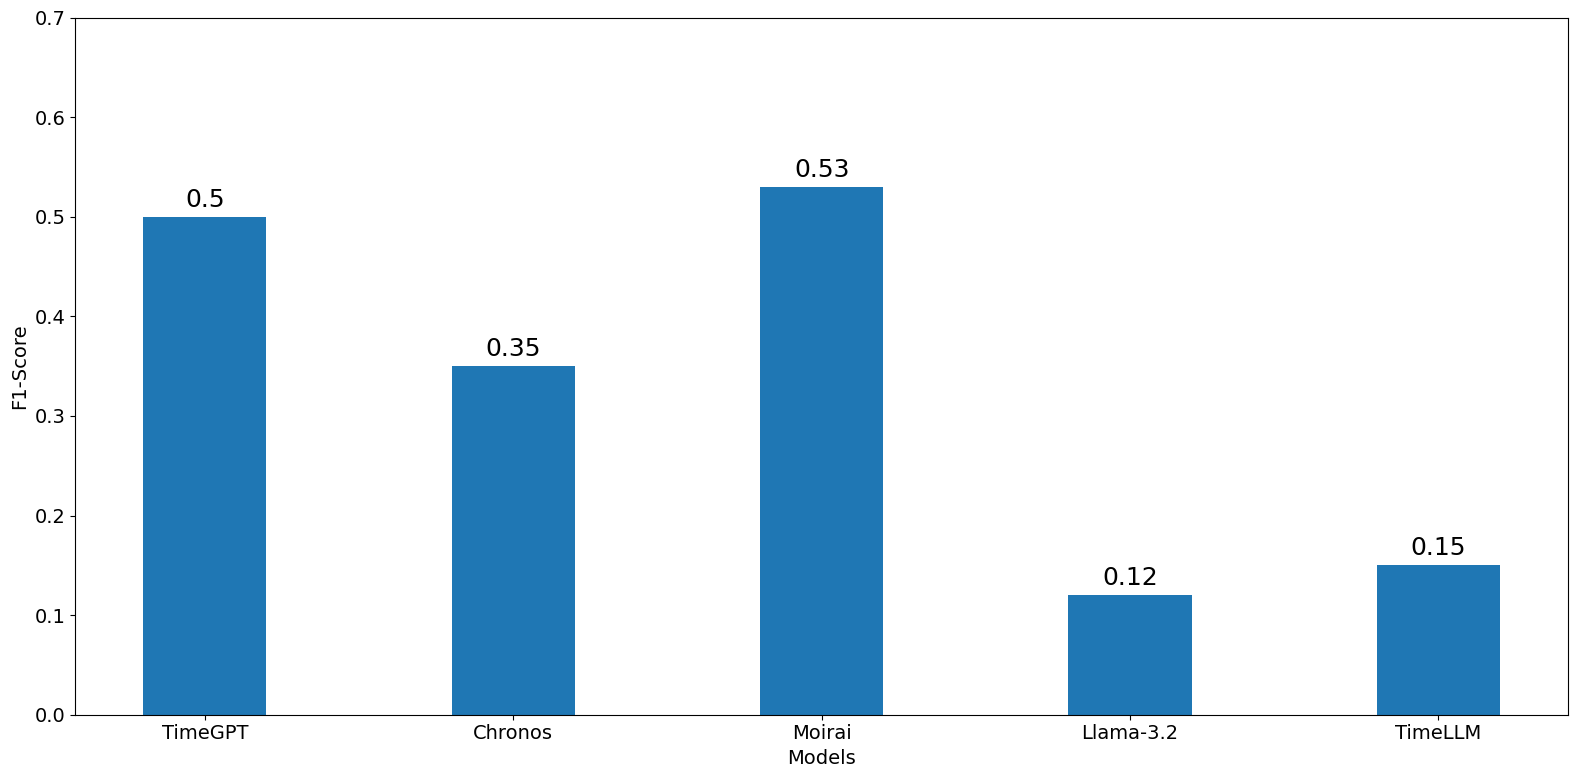

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

x = ['TimeGPT', 'Chronos', 'Moirai', 'Llama-3.2', 'TimeLLM']
y = [0.50, 0.35, 0.53, 0.12, 0.15]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('F1-Score')
ax.set_ylim(0,  0.7)

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.01, s=str(v), ha='center', fontsize=18)

plt.tight_layout()
plt.savefig("figures/CH09_codefig4_peixeiro2.png", dpi=300)